In [11]:
from langgraph.graph import START, END, StateGraph
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.tools import tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.document_loaders import PyPDFLoader
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
from IPython.display import display, Image
import gradio as gr
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
import uuid
from langgraph.errors import GraphRecursionError

In [12]:
load_dotenv(override=True)

True

In [13]:
class RAG_Setup:
    def __init__(self):
        self.embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
        self.vector_store = Chroma(
            collection_name="medical_history_collection",
            embedding_function=self.embeddings,
            persist_directory="data/patient_record_db", 
        )

    def _calculate_file_hash(self, file_path):
        import hashlib
        sha256 = hashlib.sha256()
        with open(file_path, 'rb') as f:
            while chunk := f.read(8192):
                sha256.update(chunk)
        return sha256.hexdigest()

    def _is_file_uploaded(self, file_hash):
        results = self.vector_store.get(
            where={"file_hash": file_hash},
            limit=1
        )
        return len(results['ids']) > 0
    
    def _extract_content(self, file_path):
        pdf_loader = PyPDFLoader(file_path)
        content = pdf_loader.load()
        return content

    def _split_content(self, content):
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, add_start_index=True)
        chunks = text_splitter.split_documents(content)
        return chunks

    def _embed_content(self, chunks):
        self.vector_store.add_documents(chunks)

    def store_data(self, file_path):

        file_hash = self._calculate_file_hash(file_path)
        
        if self._is_file_uploaded(file_hash):
            return {
                "status": "skipped",
                "message": f"File already exists in database"
            }
        
        try:
            content = self._extract_content(file_path)
            chunks = self._split_content(content)
            
            for chunk in chunks:
                chunk.metadata.update({
                    'file_hash': file_hash
                })
            
            self._embed_content(chunks)
            
            return {
                "status": "success",
                "message": f"File successfully uploaded",
                "chunks": len(chunks)
            }
        except Exception as e:
            return {
                "status": "error",
                "message": f"Failed to upload file: {str(e)}"
            }

    def retrieve_info(self, query: str):
        try:
            results = self.vector_store.similarity_search(query, k=5)
            print("printing tool results", results)
            
            if not results:
                return "No medical history found for this query."
            
            content = "\n\n---DOCUMENT---\n\n".join([doc.page_content for doc in results])
            
            return content
        
        except Exception as e:
            return "Failed to retrieve medical record"
    

In [14]:
rag = RAG_Setup()

In [15]:
@tool
def check_medical_history(query: str):
    '''Retrieves relevent medical history of the user

    Args:
        query: medical history to be searched for
    '''
    return rag.retrieve_info(query)

In [16]:
serper = GoogleSerperAPIWrapper()
@tool
def web_search(query: str):
    ''' Search web for answering queries with latest information
    Args:
        query: query to be searched on the web
    '''
    print("Websearch tool calling")
    return serper.run(query)

In [17]:
tools = [web_search, check_medical_history]

In [18]:
llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-V3",
    task="text-generation",
    max_new_tokens=1024,
    do_sample=False,
    repetition_penalty=1.03,
    provider="auto", 
)
llm = ChatHuggingFace(llm=llm)
llm_with_tools = llm.bind_tools(tools)

In [19]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [20]:
REACT_SYSTEM_PROMPT = '''You are a helpful medical assistant with access to patient records and web search.

You solve problems using the ReAct (Reasoning and Acting) framework:
1. Thought: Reason about what information you need
2. Action: Call the appropriate tool
3. Observation: Receive the tool result
4. Repeat until you can answer confidently

AVAILABLE TOOLS:
- check_medical_history: Search patient's personal medical records (medications, appointments, conditions, lab results)
- web_search: Search the web for general medical information, drug interactions, side effects, treatment guidelines

MULTI-STEP REASONING EXAMPLES:

Example 1: Drug Interaction Query
User: "Can I take ibuprofen with my medicines?"
Thought: I need to first check what medications the patient is currently taking.
Action: check_medical_history(query="current medications")
Observation: Patient takes Metformin, Lisinopril, Atorvastatin, Levothyroxine, Omeprazole, Aspirin, Vitamin D3
Thought: Now I need to check if ibuprofen interacts with these specific medications, especially Aspirin (both are NSAIDs).
Action: web_search(query="ibuprofen interactions with aspirin metformin lisinopril atorvastatin")
Observation: Ibuprofen + Aspirin can reduce aspirin's cardioprotective effect. Risk of bleeding increases. Should avoid concurrent use.
Answer: Based on your current medications, taking ibuprofen with aspirin is not recommended...

Example 2: Simple Patient Query
User: "What medications am I taking?"
Thought: This is a straightforward question about the patient's records.
Action: check_medical_history(query="current medications")
Observation: [Patient medication list]
Answer: You are currently taking...

Example 3: General Medical Question
User: "What are the side effects of Metformin?"
Thought: This is a general medical question, not specific to the patient's records.
Action: web_search(query="Metformin side effects")
Observation: [Web search results]
Answer: Common side effects of Metformin include...

CRITICAL RULES:
- Use multiple tools when needed - don't stop after one tool if more information is required
- Think step-by-step and be thorough
'''

In [21]:
def personal_assistant(state: State):
    print("assistant responses:")
    print(state["messages"])
    messages = state["messages"]
    return {
        "messages":  llm_with_tools.invoke(messages)
    }

In [22]:
db_path = 'data/long_term_memory.db'
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

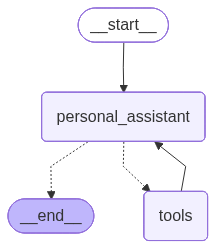

In [23]:
graph_builder = StateGraph(State)
graph_builder.add_node("personal_assistant", personal_assistant)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_conditional_edges("personal_assistant", tools_condition, {"tools": "tools", "__end__": END})
graph_builder.add_edge(START, "personal_assistant")
graph_builder.add_edge("tools", "personal_assistant")

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
from transformers import pipeline

transcriber = pipeline("automatic-speech-recognition", model="openai/whisper-small")

Device set to use mps:0


In [25]:
import json
session_id = str(uuid.uuid4())
print(session_id)

def chat(user_message, uploaded_file, message_history):
    """
    Handle chat with text, audio, or file upload.
    The LLM decides what to do with uploaded files.
    """
    user_query_parts = []
    try: 
        if user_message and user_message.strip():
            user_query_parts.append(user_message)
        
        if uploaded_file is not None:
            result = rag.store_data(uploaded_file)
            result_str = json.dumps(result, indent=2)
            user_query_parts.append(f"""A medical document was uploaded. Here are the upload details: {result_str} Please inform the user about the upload status in a friendly, professional way.""")

        if not user_query_parts:
            return message_history, "", None, None
        
        user_query = (' ').join(user_query_parts)
        
        config = {"configurable": {"thread_id": session_id}, "recursion_limit" : 25}
        current_state = graph.get_state(config)
        
        if not current_state.values.get("messages"):
            messages = {
                "messages": [
                    {"role": "system", "content": REACT_SYSTEM_PROMPT},
                    {"role": "user", "content": user_query}
                ]
            }
        else:
            messages = {"messages": [{"role": "user", "content": user_query}]}

        result = graph.invoke(
            messages,
            config=config
        )
        
        last_message = result["messages"][-1].content
        
        updated_history = message_history + [
            {"role": "user", "content": user_message},
            {"role": "assistant", "content": last_message}
        ]
        
        return updated_history, "", None
        
    except GraphRecursionError:
        error_message = "This query is too complex and exceeded the reasoning limit. Please simplify or break it into smaller questions."
        return message_history + [
            {"role": "assistant", "content": error_message}
        ], "", None
       
    except Exception as e:
        error_message = f"Error: {str(e)}"
        return message_history + [
            {"role": "assistant", "content": error_message}
        ], "", None

b0196b9a-8b29-407c-b736-e2d6d6abeeb7


In [26]:
def transcribe_audio(audio, current_text, file_input, message_history):
    if audio is None:
        return message_history, current_text, None, file_input
    
    transcript = transcriber(audio)["text"].strip()
    
    updated_history, cleared_text, cleared_file = chat(
        transcript, 
        file_input, 
        message_history
    )
    
    return updated_history, current_text, None, cleared_file

with gr.Blocks(title="Medical Assistant") as demo:
    gr.Markdown("# 🏥 Medical Assistant")
    gr.Markdown("Ask questions using text, voice, or upload medical documents")
    
    chatbot = gr.Chatbot(label="Conversation", height=400)
    
    with gr.Row():
        with gr.Column(scale=3):
            text_input = gr.Textbox(
                placeholder="Type your medical question here...",
                label="Text Input",
                lines=2
            )
        with gr.Column(scale=1):
            audio_input = gr.Audio(
                sources=["microphone"],
                type="filepath",
                label="🎤 Voice"
            )
        with gr.Column(scale=1):
            file_input = gr.File(
                label="📄 Upload PDF",
                file_types=[".pdf"],
                type="filepath"
            )
    
    with gr.Row():
        submit_btn = gr.Button("Send", variant="primary")
        clear_btn = gr.ClearButton([chatbot, text_input, audio_input, file_input])
    
    gr.Markdown("### Tips:\n- Upload medical records (PDFs) and I'll process them automatically\n- Ask about medications, interactions, or symptoms\n- I can store new medical information you share")
    
    submit_btn.click(
        chat,
        inputs=[text_input, file_input, chatbot],
        outputs=[chatbot, text_input, file_input]
    )
    
    text_input.submit(
        chat,
        inputs=[text_input, file_input, chatbot],
        outputs=[chatbot, text_input, file_input]
    )

    audio_input.change(
        transcribe_audio,
        inputs=[audio_input, text_input, file_input, chatbot],
        outputs=[chatbot, text_input, audio_input, file_input] 
    )

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a92b3a19656a2e6316.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [27]:
import atexit
atexit.register(lambda: conn.close())

<function __main__.<lambda>()>